In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, copy
from em.signal_utils import delay_signal

In [2]:
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.autolayout'] = True
mpl.rcParams.update({'axes.grid': True})

In [3]:
from em.signal_utils import gen_ir

toas_gt = np.array([134.221, 143.1, 202.01, 240.9])
gains_gt = np.array([1., .5, .4, .35])
fdflen = 41
ir_gt = gen_ir(int(toas_gt.max()+100), toas_gt, gains_gt, fdflen)
N = ir_gt.shape[0]
print(N)

from em.signal_utils import gen_chirp
from numpy.fft import fft, rfft, ifft, irfft, fftfreq, rfftfreq
f0 = 0.5 / 100  # unit is periods per sample. 0.5 is Nyquist frequency
f1 = 0.45
chp_len = 1000
sig_len = chp_len + len(ir_gt)
chp_signal = gen_chirp(f0, f1, chp_len, sig_len)
chp_signal_fft = rfft(chp_signal)

340


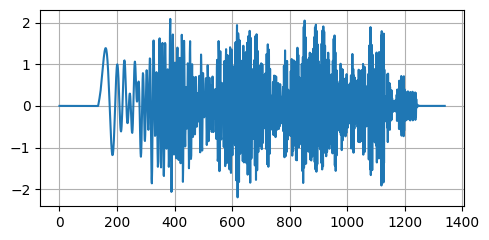

In [4]:
%matplotlib inline
mic_signal = np.convolve(chp_signal, ir_gt, mode='full')[:sig_len]
plt.plot(mic_signal[:])
plt.show()

## Rxs and delay_signal

### Check that np.dot(mic_signal, delay_signal(chp_signal)) and Rxs are same, and that the former interpolates the latter properly.

In [45]:
Rxsfull = np.correlate(mic_signal, chp_signal, mode='full')
toa_range = [100, 300]
nmin, nmax = np.array(toa_range, dtype=int) + len(chp_signal) - 1
Rxs = Rxsfull[nmin:nmax]

Jfactor = 50
Jvals = np.empty(Jfactor*(toa_range[1]-toa_range[0]))
for i in range(len(Jvals)):
    Jvals[i] = np.dot(
        mic_signal, 
        delay_signal(chp_signal, i/Jfactor+toa_range[0], flen=41)
    )

%matplotlib qt
xaxis = np.arange(Jfactor*len(Rxs))/Jfactor
plt.plot(xaxis[::Jfactor], Rxs, label='Rxs', marker='.')
plt.plot(xaxis, Jvals, label='Jvals', alpha=0.7)
# plt.plot(ir_gt[100:300]*1000, label='ir_gt', alpha=0.7)
plt.legend()
plt.show()
# PASSED 

In [46]:
toas_gt - toa_range[0]

array([ 34.221,  43.1  , 102.01 , 140.9  ])

### Check minimize_scalar with J

In [48]:
from scipy.optimize import minimize_scalar

cand = 141  # peak in Rxs; actual toa is cand+toa_range[0]
def J(c):
    return -np.dot(
        mic_signal, 
        delay_signal(chp_signal, c+toa_range[0], flen=41)
    )

res = minimize_scalar(
    J,
    method='bounded',
    # bracket=[cand-1, cand, cand+1],
    bracket=[cand-1, cand+1],
    # bounds=toa_range,
    # bounds=[cand-10, cand+10],
    bounds=[cand-2, cand+2],
    options={
        'maxiter': 20,
        'disp': 3,
        'xatol': 1e-3,
    }
)
print(res.x, res.success, )

 
 Func-count     x          f(x)          Procedure
    1        140.528     -143.586        initial
    2        141.472     -106.819        golden
    3        139.944     -24.4023        golden
    4        140.878     -175.412        parabolic
    5        140.911     -175.543        parabolic
    6        140.903      -175.56        parabolic
    7        140.902      -175.56        parabolic
    8        140.902      -175.56        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )
140.90244961165385 True


In [52]:
res.success

True

: 

In [50]:
from scipy.optimize import show_options
show_options('minimize_scalar', method='bounded', disp=True)

Options
-------
maxiter : int
    Maximum number of iterations to perform.
disp: int, optional
    If non-zero, print messages.
        0 : no message printing.
        1 : non-convergence notification messages only.
        2 : print a message on convergence too.
        3 : print iteration results.
xatol : float
    Absolute error in solution `xopt` acceptable for convergence.
